# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [0]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [0]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [0]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))

Loaded feature names:  126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [0]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

Explained variance ratio for 1 principal components: 0.16404331279333878
Explained variance ratio for 2 principal components: 0.29727810148780454
Explained variance ratio for 3 principal components: 0.3990126667087559
Explained variance ratio for 4 principal components: 0.46964623105175035
Explained variance ratio for 5 principal components: 0.5083126783858753
Explained variance ratio for 6 principal components: 0.5451207238504957
Explained variance ratio for 7 principal components: 0.5764030922026381
Explained variance ratio for 8 principal components: 0.6037403406866158
Explained variance ratio for 9 principal components: 0.6299052271741035
Explained variance ratio for 10 principal components: 0.6522145741707888
Explained variance ratio for 11 principal components: 0.6726928876177025
Explained variance ratio for 12 principal components: 0.6913754007050283
Explained variance ratio for 13 principal components: 0.7086719156668696
Explained variance ratio for 14 principal components: 0.7

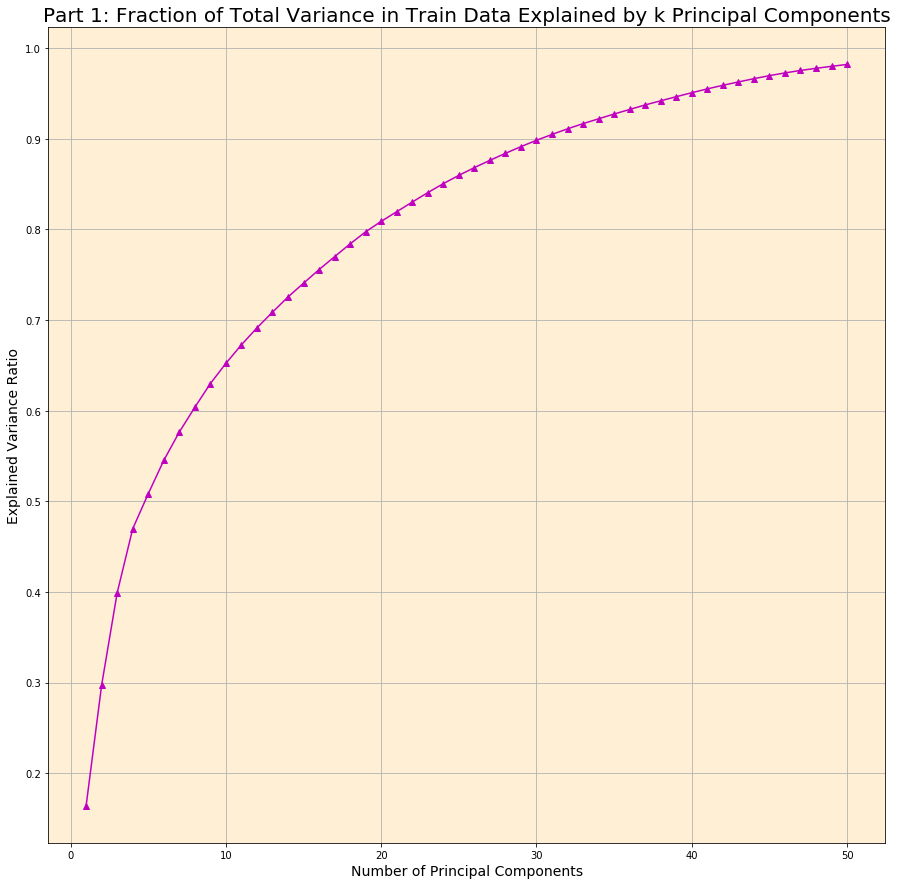

In [0]:
def P1():
### STUDENT START ###

  variance_ratio_array = [] #array to append Explained Variance Ratio to for # of PCs on our Y axis
  for k in range(1,51): #loop through 1-50
    pca = PCA(n_components=k) 
    pca.fit_transform(train_data)

    print("Explained variance ratio for " + str(k) + " principal components: " + str(np.sum(pca.explained_variance_ratio_)))

    variance_ratio_array.append(float(np.sum(pca.explained_variance_ratio_)))

  #Plotting
  num_of_principal_components_array = [i for i in range(1,51)] #create an array from 1-50 for our x axis
  fig, ax = plt.subplots() 
  fig.set_size_inches(15, 15) #plot size
  ax.set_title("Part 1: Fraction of Total Variance in Train Data Explained by k Principal Components", fontsize = 20)
  ax.set_xlabel('Number of Principal Components', fontsize = 14)
  ax.set_ylabel('Explained Variance Ratio', fontsize = 14)
  ax.plot(num_of_principal_components_array,variance_ratio_array, '-m^')  
  ax.set_facecolor('papayawhip')
  ax.grid()
    #print(k)



  #print(np.sum(pca.explained_variance_ratio_))
  #print(pca.components_)
### STUDENT END ###

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

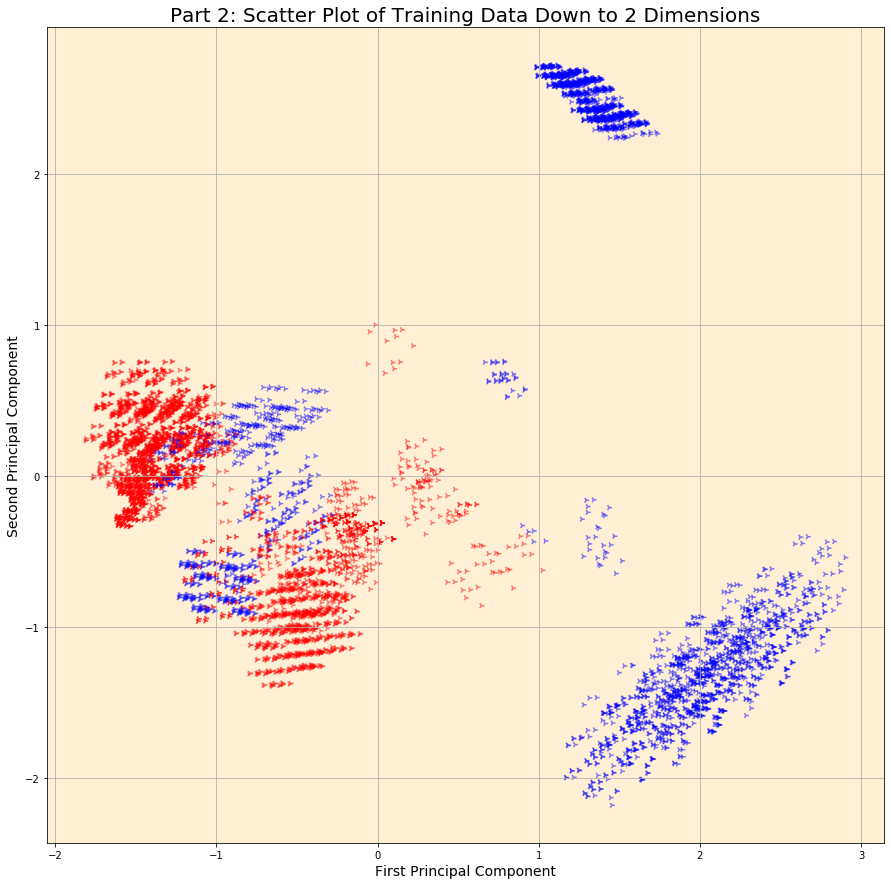

In [0]:
def P2():
### STUDENT START ###
  pca = PCA(n_components=2) #initialize pca with first 2 principal components
  principal_components = pca.fit_transform(train_data) #fit train data to pca
  #print(principal_components)

  colors = np.where(train_labels, 'blue', 'red') #initialize color array, set the point blue if true, else set it as red
  #print(colors)
  fig, ax = plt.subplots(figsize=(15,15)) #define plot size

  ax.scatter(principal_components[:,0],principal_components[:,1],c=colors,marker="4",alpha=0.5, picker=False) #scatter plot with colors, blue if positive, red if negative
  ax.set_title('Part 2: Scatter Plot of Training Data Down to 2 Dimensions', fontsize = 20) #plot title
  ax.set_xlabel('First Principal Component', fontsize = 14) #x label
  ax.set_ylabel('Second Principal Component', fontsize = 14) #y label
  ax.set_facecolor('papayawhip') #grid background color
  ax.grid() #gridlines

### STUDENT END ###

P2()

### Part 3:

Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

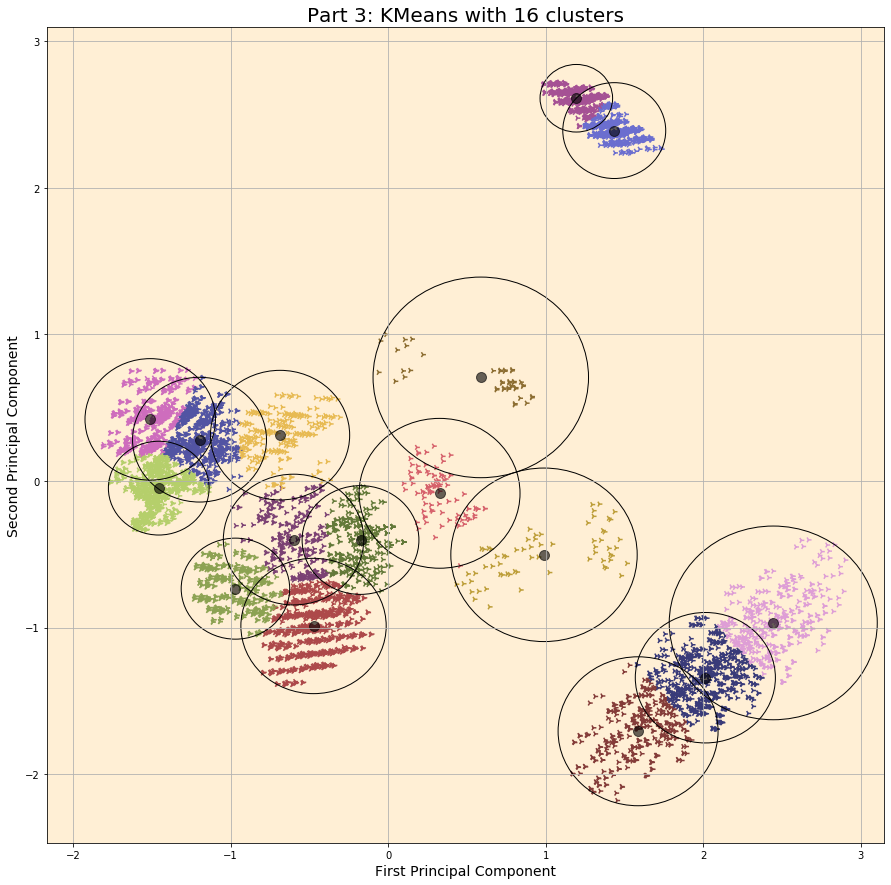

In [0]:
def P3():

### STUDENT START ###

  #set cluster size
  cluster_count = 16

  #initialize pca and grab first 2 components
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(train_data)

  #initialize kmeans
  kmeans = KMeans(n_clusters=cluster_count, random_state=0).fit(principal_components)

  #kmeans labels
  y_kmeans = kmeans.predict(principal_components)
  
  #cluster center
  centers = kmeans.cluster_centers_
  
  #for int 0-15 (since we have 16 clusters)
  #get max distance / radius for each cluster
  max_dist_array = []
  for i in range(cluster_count):
    #print(i)
    cluster_points = principal_components[y_kmeans==i] #get points which k means has determined belong to each cluster (y_kmeans==i)
    cluster_center = centers[i] #get center point

    #calculate distances and append max distance to list
    max_dist = 0
    
    for j in cluster_points:
      dist = np.linalg.norm(j - kmeans.cluster_centers_[i]) #calculate euclidean distance 
      if dist > max_dist: #get max distance
        max_dist = dist
        max_point = j
      else:
        continue

    max_dist_array.append(max_dist) #once we have the max distance, append to array and iterate through next label

  ####Plot clusters ###
  fig, ax = plt.subplots(figsize=(15,15))
  ax.scatter(principal_components[:, 0], principal_components[:, 1], c=y_kmeans, marker="4", cmap='tab20b')
  #Plot Labels
  plt.grid() #gridlines
  ax.set_title('Part 3: KMeans with ' + str(cluster_count) + ' clusters', fontsize = 20)
  ax.set_xlabel('First Principal Component', fontsize = 14)
  ax.set_ylabel('Second Principal Component', fontsize = 14)
  ax.set_facecolor('papayawhip') #background color

  #Plot circles
  for i, v in enumerate(max_dist_array):
    plt.scatter(centers[i, 0], centers[i, 1], c='black', s=100, alpha=0.6)
    circle = plt.Circle(centers[i],radius=v,fill=False)
    ax.add_patch(circle)
### STUDENT END ###
P3()

### Part 4:

Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Log scale: values of z <= 0 have been masked


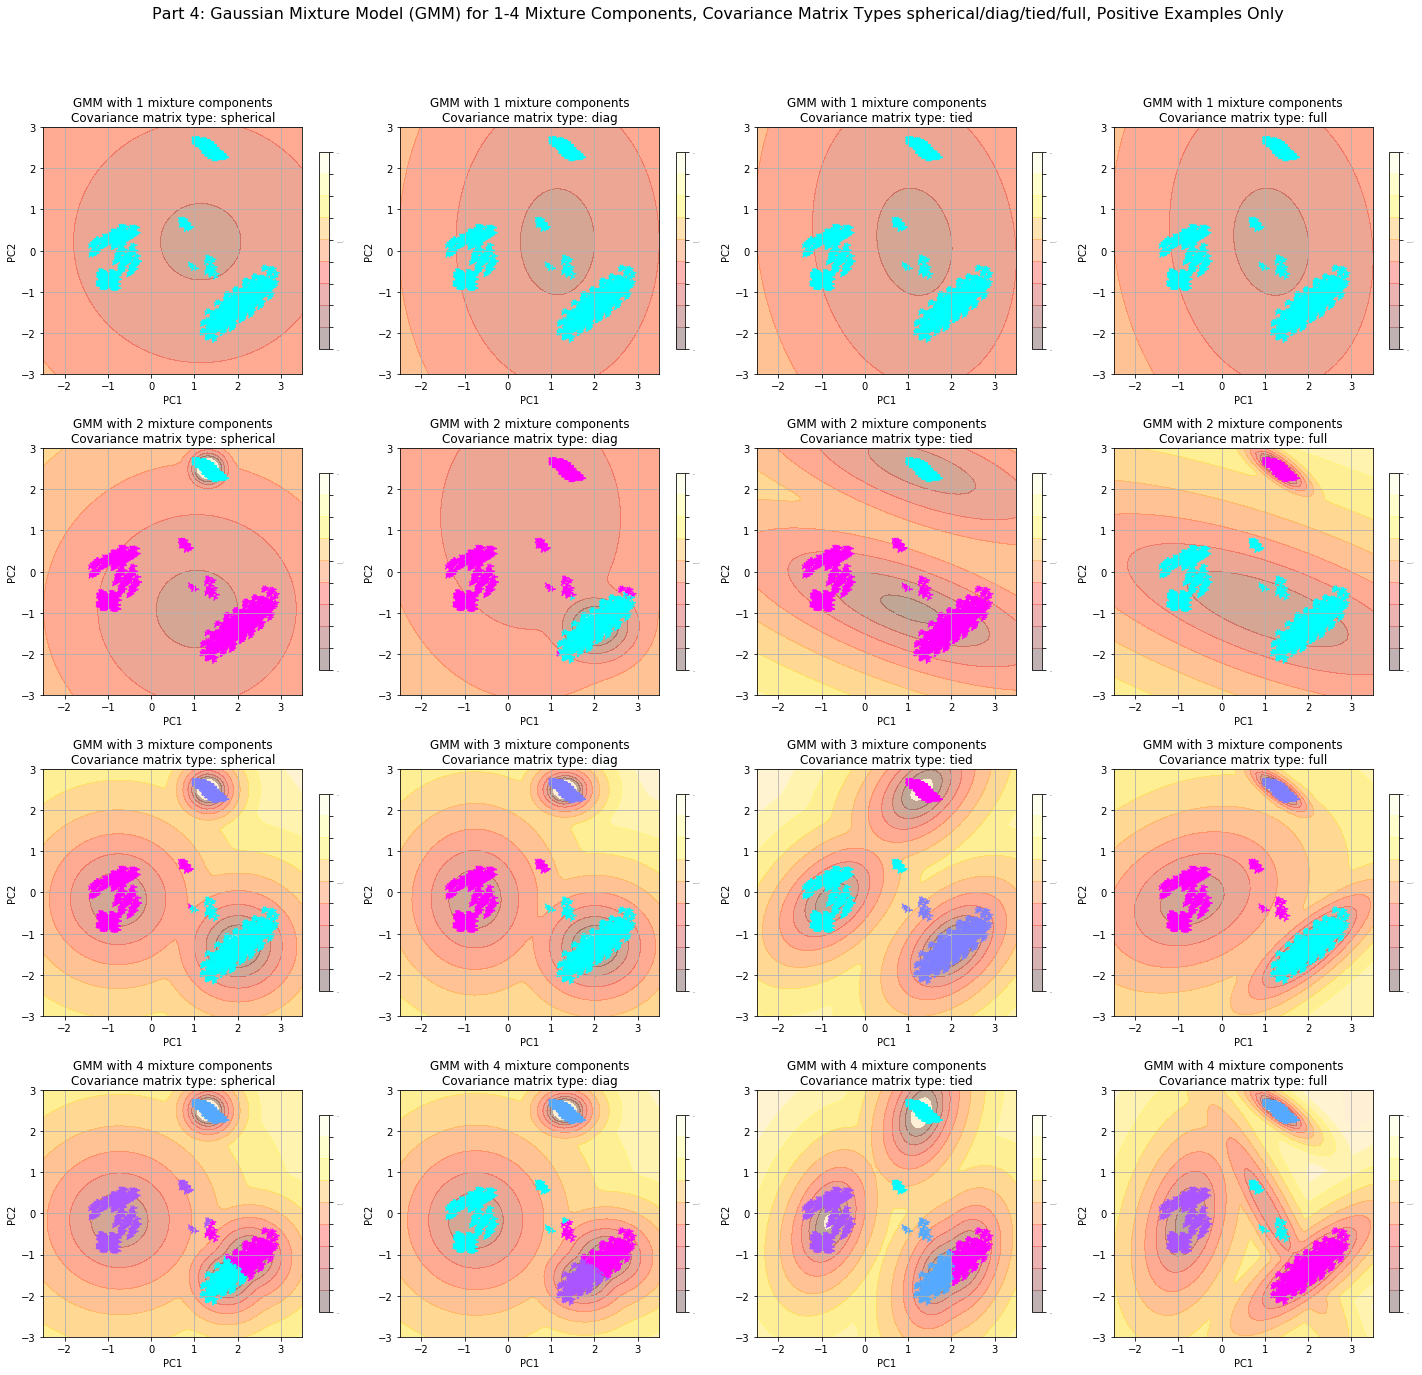

In [0]:
#####subplot version

def P4():
### STUDENT START ###
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(train_data)[train_labels == 1]
  count = 1
  fig = plt.figure() #initializing plot
  fig.set_size_inches(25,21)
  fig.suptitle('Part 4: Gaussian Mixture Model (GMM) for 1-4 Mixture Components, Covariance Matrix Types spherical/diag/tied/full, Positive Examples Only', size=16)

  cov_matrix_type = ['spherical', 'diag', 'tied', 'full'] #covariance matrix types we want to loop through

  plt.subplots_adjust(left=0.125, bottom= 0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.3)
  
  for i in range(1,5): #loop through 1-4 GMM mixture components
    for j in cov_matrix_type: #loop through our array of covariance types
      gmm = GaussianMixture(n_components = i, covariance_type = j)
      gmm.fit(principal_components)

      y_hat = gmm.predict(principal_components)

      #plt.figure(figsize=(10, 8))

      # display predicted scores by the model as a contour plot
      x = np.linspace(-2.5, 3.5) #set limits of x
      y = np.linspace(-3., 3.) #set limits of y
      X, Y = np.meshgrid(x, y)
      XX = np.array([X.ravel(), Y.ravel()]).T
      Z = -gmm.score_samples(XX)
      Z = Z.reshape(X.shape)

      ax = fig.add_subplot(4, 4, count) #add to 4*4 grid
      ax.set_facecolor('papayawhip')
      ax.set_xlabel('PC1')
      ax.set_ylabel('PC2')
      count = count + 1 #add 1 to the count

      #CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=10.0),
      CS = plt.contourf(X, Y, Z,norm=LogNorm(vmin=1.0, vmax=100.0),
                             levels=np.logspace(0, 2, 10), alpha=.3, cmap='hot') #using contourf instead of countour for filled contour lines 
                      #levels=np.logspace(0, 1, 10), alpha=.2, cmap='hot')
      CB = plt.colorbar(CS, shrink=0.8, extend='both')
      CB.ax.tick_params(labelsize=0) #removing labels on tick bar
      plt.scatter(principal_components[:, 0], principal_components[:, 1], c=y_hat,marker="4",  cmap='cool') 
      plt.title("GMM with " + str(i) + " mixture components\nCovariance matrix type: " + j)
      plt.grid()
      plt.axis('tight')
### STUDENT END ###

P4()

### Part 5:

Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [0]:
def P5():
### STUDENT START ###

  pca = PCA(n_components=2)
  principal_components_train = pca.fit_transform(train_data) #	Fit the model with X and apply the dimensionality reduction on X.

  gmm1 = GaussianMixture(n_components = 4, covariance_type = 'full') #first gmm for positive examples
  gmm2 = GaussianMixture(n_components = 4, covariance_type = 'full') #second gmm for negative examples

  positive_labels_tf_train_array = (train_labels == 1) #T/F boolean masking array if train_label = 1
  negative_labels_tf_train_array = (train_labels == 0) #T/F boolean masking array if train_label = 0

  pos_pc_train = principal_components_train[positive_labels_tf_train_array]
  neg_pc_train = principal_components_train[negative_labels_tf_train_array]

  gmm1.fit(pos_pc_train)
  gmm2.fit(neg_pc_train)

  pca_dim_red_test = pca.transform(test_data) #Apply dimensionality reduction to test_ data

  pos_gmm1 = np.exp(gmm1.score_samples(pca_dim_red_test))
  false_gmm2 = np.exp(gmm2.score_samples(pca_dim_red_test))

  #Predicted results - return 1 if gmm1 is higher, else return 0
  pred_results = (pos_gmm1 > false_gmm2) * 1

  accuracy_denominator = pred_results.shape[0] #length of array

  comp_array = (pred_results == test_labels) * 1 #compare our predicted results against our test labels
  accuracy_numerator = np.sum(comp_array) #how many matches we got

  accuracy = accuracy_numerator/accuracy_denominator #calculate accuracy

  print("The accuracy is: " + str(accuracy))

### STUDENT END ###

P5()

The accuracy is: 0.9501779359430605


### Part 6:

Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [0]:
import pandas as pd #Importing pandas to output table nicely
from IPython.display import display, HTML #Importing pandas to output table nicely

def P6():
### STUDENT START ###

  #taking our function from P5 and turning it into a function we can loop through 
  def GMM_PCA_test(pca_components, mixture_components, covariance_type):
    pca = PCA(n_components=pca_components)
    principal_components_train = pca.fit_transform(train_data) #	Fit the model with X and apply the dimensionality reduction on X.

    gmm1 = GaussianMixture(n_components = mixture_components, covariance_type = covariance_type)
    gmm2 = GaussianMixture(n_components = mixture_components, covariance_type = covariance_type)

    positive_labels_tf_train_array = (train_labels == 1)
    negative_labels_tf_train_array = (train_labels == 0)

    pos_pc_train = principal_components_train[positive_labels_tf_train_array]
    neg_pc_train = principal_components_train[negative_labels_tf_train_array]

    gmm1.fit(pos_pc_train)
    gmm2.fit(neg_pc_train)

    pca_dim_red_test = pca.transform(test_data) #Apply dimensionality reduction to test_ data

    pos_gmm1 = np.exp(gmm1.score_samples(pca_dim_red_test))
    false_gmm2 = np.exp(gmm2.score_samples(pca_dim_red_test))

    #Predicted results - return 1 if gmm1 is higher, else return 0
    pred_results = (pos_gmm1 > false_gmm2) * 1

    accuracy_denominator = pred_results.shape[0] #length of array

    comp_array = (pred_results == test_labels) * 1 #compare our predicted results against our test labels
    accuracy_numerator = np.sum(comp_array) #how many matches we got

    accuracy = accuracy_numerator/accuracy_denominator #calculate accuracy

    #print("# of PCA Components: " + str(pca_components) + ", # of Mixture Components: " + str(mixture_components) + ", covariance matrix type: " + str(covariance_type) + ", accuracy: " + str(accuracy))

    return accuracy

  #initialize covariance matrix type vars to loop through
  cov_matrix_type = ['spherical', 'diag', 'tied', 'full'] 

  #initiialize vars
  optimum_pca_components = 0
  optimum_mixture_components = 0
  optimum_cov_matrix_type = 0
  max_accuracy = 0

  #lists to append to for our Pandas table/output
  n_components_array = []
  pca_components_array = []
  mixture_components_array =  []
  cov_matrix_type_array = []
  cur_accuracy_array = []

  #( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

  for i in range(1,16): #num of PCA components we're testing - 1 through 10
    for j in range(1,16): #num of GMM mixture components we're testing - 1 through 10
      for k in cov_matrix_type: #loop through covariance matrix types
        if ((i+i) * j * 2) <= 50: #try combination of parameters  if there would be 50 or fewer parameters
          cur_accuracy = GMM_PCA_test(i, j, k)
          #print("# of PCA Components: " + str(i) + ", # of Mixture Components: " + str(j) + ", covariance matrix type: " + str(k) + ", accuracy: " + str(cur_accuracy))
          pca_components_array.append(i)
          mixture_components_array.append(j)
          cov_matrix_type_array.append(k)
          cur_accuracy_array.append(cur_accuracy)
          n_components_array.append((i+i) * j * 2)
          if cur_accuracy > max_accuracy:
            max_accuracy = cur_accuracy
            optimum_pca_components = i
            optimum_mixture_components = j
            optimum_cov_matrix_type = k
          else:
            continue
        else:
          continue
  
  df = pd.DataFrame({"PCA_Components": pca_components_array, 
                         "GMM_Mixture_Components":mixture_components_array,
                         "Covariance_Matrix_type": cov_matrix_type_array, 
                         "N_Components": n_components_array,
                         "Accuracy":cur_accuracy_array,
                     })


  print("******Finding the best combination of PCA Components, Mixture Components, Covariance Matrix Type******")
  display(df.sort_values(by=['Accuracy'], ascending = False)) #display pd table sorted by highest accuracy value

  print("The combination of parameters that resulted in the best accuracy was:")
  print("Optimum number of PCA components: " + str(optimum_pca_components))
  print("Optimum number of GMM components: " + str(optimum_mixture_components))
  print("Covariance Type: " + str(optimum_cov_matrix_type))
  print("Max accuracy: " + str(max_accuracy))
### STUDENT END ###

P6()

******Finding the best combination of PCA Components, Mixture Components, Covariance Matrix Type******


,PCA_Components,GMM_Mixture_Components,Covariance_Matrix_type,N_Components,Accuracy
98,4,3,tied,48,0.969751
115,6,2,full,48,0.966192
135,11,1,full,44,0.965302
134,11,1,tied,44,0.965302
118,7,1,tied,28,0.965302
...,...,...,...,...,...
93,4,2,diag,32,0.843416
89,4,1,diag,16,0.843416
79,3,2,full,24,0.818505
90,4,1,tied,16,0.816726


The combination of parameters that resulted in the best accuracy was:
Optimum number of PCA components: 4
Optimum number of GMM components: 3
Covariance Type: tied
Max accuracy: 0.9697508896797153
